# Elements logiciels pour le traitement des données en grande dimension

In [1]:
%matplotlib inline

## Installation de pyspark

In [2]:
import findspark
sparkHome = "C:\Dev\Spark\spark-2.2.0-bin-hadoop2.7"
findspark.init(sparkHome)

### Petit essai pour calculer PI

In [3]:
def printSpendTime (startTime) :
    spendTime = time.time() - startTime
    m, s = divmod(spendTime, 60)
    h, m = divmod(m, 60)
    print("--------------------------------------------------")
    print ("-----   Temps écoulé : %dh%02dm%02ds" % (h, m, s))
    print("--------------------------------------------------")
    return

In [4]:
'''
import pyspark
import random
import time

startTime = time.time()

sc = pyspark.SparkContext(appName="Pi")
num_samples = 100000000

def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

count = sc.parallelize(range(0, num_samples)).filter(inside).count()

pi = 4 * count / num_samples
print(pi)

sc.stop()

printSpendTime(startTime)
'''

'\nimport pyspark\nimport random\nimport time\n\nstartTime = time.time()\n\nsc = pyspark.SparkContext(appName="Pi")\nnum_samples = 100000000\n\ndef inside(p):     \n  x, y = random.random(), random.random()\n  return x*x + y*y < 1\n\ncount = sc.parallelize(range(0, num_samples)).filter(inside).count()\n\npi = 4 * count / num_samples\nprint(pi)\n\nsc.stop()\n\nprintSpendTime(startTime)\n'

## Arbre k-d classique

### Création d'un jeu de données

In [5]:
import numpy as np
import pandas

n = 10
data = pandas.DataFrame(np.random.rand(n,2)*100,  columns = ['X', 'Y'])
data.iloc[0:10, ]

,X,Y
0,19.456840,1.079894
1,74.237529,94.562929
2,85.789056,30.568255
3,19.421939,36.252476
4,68.890860,56.133032
5,62.424507,84.795963
6,44.789680,75.490246
7,71.804915,30.775283
8,52.611317,71.349616
9,16.521588,10.311538


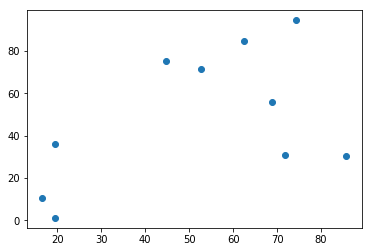

In [6]:
import matplotlib.pyplot as plt

plt.plot(data[['X']], data[['Y']], 'o')
plt.show()

### Définition d'une structure de données pour les arbres binaires

In [7]:
### Classe permettant de definir un arbre binaire simple
### Il se constitue d'un noeud racine, de deux sous-arbres
### et des donnees correspondant au noeud racine
class Tree(object) :
    
    ## Constructeur simple
    def __init__(self) :
        self.left = None
        self.right = None
        self.key = None
        self.data = None
    
    ## Reprensation de l'arbre sous forme de chaine
    ## de caracteres
    def __str__(self) :
        return self.strRec(0)
    
    ## Represente l'arbre sous forme de chaine de caracteres
    ## de facon recursive
    def strRec(self, depth) :
        line = "-" * 3 * depth
        res = line + str(self.data)
        if self.left :
            res += "\n" + self.left.strRec(depth+1)
        if self.right :
            res += "\n" + self.right.strRec(depth+1)
        return res

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines

### Trace un arbre k-d (classe 'Tree') de facon recursive
def pltTreeRec(ax, tree, keyX, keyY, xLim, yLim) :
    if tree :
        x, y = tree.data[keyX], tree.data[keyY]
        if tree.key == keyX :
            pltTreeRec(ax, tree.left, keyX, keyY, (xLim[0], x), yLim)
            pltTreeRec(ax, tree.right, keyX, keyY, (x, xLim[1]), yLim)
            ax.add_line(lines.Line2D((x, x), yLim, linewidth=0.5, color='red'))
        elif tree.key == keyY :
            pltTreeRec(ax, tree.left, keyX, keyY, xLim, (yLim[0], y))
            pltTreeRec(ax, tree.right, keyX, keyY, xLim, (y, yLim[1]))
            ax.add_line(lines.Line2D(xLim, (y, y), linewidth=0.5, color='red'))
        plt.plot(x, y, 'o', color='#1f77b4')

### Trace un jeu de donnees et l'arbre k-d associe.
### Le parametre 'tree' doit etre une instance de la 
### classe 'Tree'
def plotDataTree(data, tree) :
    colList = data.columns.values.tolist()
    keyX, keyY = colList[0], colList[1]
    ax = plt.axes()
    plt.plot(data[['X']], data[['Y']], 'o', color='#1f77b4')
    xLim, yLim = ax.get_xlim(), ax.get_ylim()
    pltTreeRec(ax, tree, keyX, keyY, xLim, yLim)
    plt.show()

### Algorithme "naïf" pour constituer un arbre k-d

<p>
On propose une première implémentation, "naïve", pour la constitution d'un arbre k-d. Le principe : on découpe de façon cyclique selon les différentes dimension ; à chaque étape on recherche la médiane du tableau (donc une opération de tri) selon la dimension courante ; on lui attache deux sous-arbres correspondants aux valeurs inférieures (resp. supérieures) à la médiane.
</p>
<p>
D'après Bentley, si on est en mesure de trouver la médiane en $O(n)$, la complexité de l'algorithme est en $O(n\log(n))$.
</p>

In [9]:
### Fonction recursive pour constituer un arbre k-d
def arbreKDnaifRec (data, colList, curCol) :
    nCol = len(colList)
    nRow = data.shape[0]
    sortCol = colList[curCol]
    if nRow == 0 :
        return None
    elif nRow == 1 :
        dataNode = data.iloc[0,]
        rootNode = Tree()
        rootNode.key = sortCol
        rootNode.data = dict()
        for col in colList :
            rootNode.data[col] = dataNode[col].item()
        return rootNode
    median = int(nRow / 2)
    if nRow % 2 == 1 :
        median = int((nRow-1) / 2)
    nextCol = (curCol + 1) % nCol
    #if nextCol > nCol :
    #    nextCol = 0
    dataSort = data.sort_values(by=sortCol)
    dataNode = dataSort.iloc[median,]
    rootNode = Tree()
    rootNode.key = sortCol
    rootNode.data = dict()
    for col in colList :
        rootNode.data[col] = dataNode[col].item()
    rootNode.left = arbreKDnaifRec(dataSort.iloc[0:median,], colList, nextCol)
    rootNode.right = arbreKDnaifRec(dataSort.iloc[(median+1):nRow,], colList, nextCol)
    return rootNode

### Fonction englobante permettant la construction d'un arbre k-d
def arbreKDnaif (data) :
    colList = data.columns.values.tolist()
    curCol = 0
    return(arbreKDnaifRec(data, colList, curCol))

{'X': 62.42450650366619, 'Y': 84.79596264552434}
---{'X': 19.42193899599378, 'Y': 36.25247633270884}
------{'X': 19.456839977561323, 'Y': 1.0798938620557585}
---------{'X': 16.521588474826167, 'Y': 10.311538211376304}
------{'X': 52.611316923595275, 'Y': 71.34961640875032}
---------{'X': 44.78967973779101, 'Y': 75.49024580830319}
---{'X': 68.89085998722558, 'Y': 56.13303183472813}
------{'X': 85.78905634455307, 'Y': 30.56825502132572}
---------{'X': 71.8049152982846, 'Y': 30.77528301627335}
------{'X': 74.2375290561811, 'Y': 94.5629288155551}


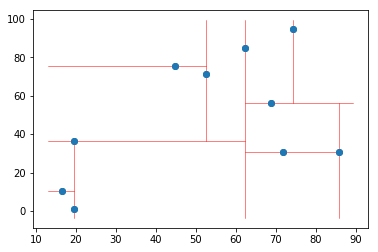

In [10]:
### Test de la fonction 'arbreKDnaif' sur le 
### jeu de donnees 'data'
arbre = arbreKDnaif(data)
print(arbre)
plotDataTree(data, arbre)

### Construction d'un arbre k-d avec pré-tri par dimension

<p>
On implémente, toujours de façon non distribuée, un algorithme de construction d'un arbre k-d où le tri selon les différentes dimension du jeu de données est fait en amont.
</p>

In [11]:
### Fonction recursive pour constituer un arbre k-d
def arbreKDpretriRec (sortedData, colList, curCol) :
    nCol = len(colList)
    sortCol = colList[curCol]
    curData = sortedData[sortCol]
    nRow = curData.shape[0]
    if nRow == 0 :
        return None
    elif nRow == 1 :
        dataNode = curData.iloc[0,]
        rootNode = Tree()
        rootNode.key = sortCol
        rootNode.data = dict()
        for col in colList :
            rootNode.data[col] = dataNode[col].item()
        return rootNode
    median = int(nRow / 2)
    if nRow % 2 == 1 :
        median = int((nRow-1) / 2)
    nextCol = (curCol + 1) % nCol
    dataNode = curData.iloc[median,]
    rootNode = Tree()
    rootNode.key = sortCol
    rootNode.data = dict()
    for col in colList :
        rootNode.data[col] = dataNode[col].item()
    leftSortedData = dict()
    rightSortedData = dict()
    for col in colList :
        leftSortedData[col] = sortedData[col][sortedData[col][sortCol]<rootNode.data[sortCol]]
        rightSortedData[col] = sortedData[col][sortedData[col][sortCol]>rootNode.data[sortCol]]
    rootNode.left = arbreKDpretriRec(leftSortedData, colList, nextCol)
    rootNode.right = arbreKDpretriRec(rightSortedData, colList, nextCol)
    return rootNode

### Fonction englobante permettant la construction d'un arbre k-d
def arbreKDpretri (data) :
    colList = data.columns.values.tolist()
    sortedData = dict()
    for col in colList :
        sortedData[col] = data.sort_values(by = col)
    curCol = 0
    return(arbreKDpretriRec(sortedData, colList, curCol))

{'X': 62.42450650366619, 'Y': 84.79596264552434}
---{'X': 19.42193899599378, 'Y': 36.25247633270884}
------{'X': 19.456839977561323, 'Y': 1.0798938620557585}
---------{'X': 16.521588474826167, 'Y': 10.311538211376304}
------{'X': 52.611316923595275, 'Y': 71.34961640875032}
---------{'X': 44.78967973779101, 'Y': 75.49024580830319}
---{'X': 68.89085998722558, 'Y': 56.13303183472813}
------{'X': 85.78905634455307, 'Y': 30.56825502132572}
---------{'X': 71.8049152982846, 'Y': 30.77528301627335}
------{'X': 74.2375290561811, 'Y': 94.5629288155551}


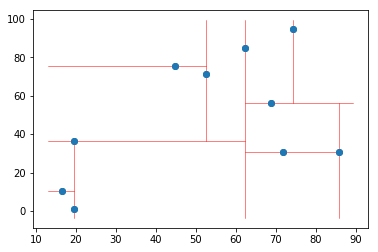

In [12]:
### Test de la fonction 'arbreKDpretri' sur le 
### jeu de donnees 'data'
### --> on doit retrouver le même arbre qu'avec 'arbreKDpretri'
arbre = arbreKDpretri(data)
print(arbre)
plotDataTree(data, arbre)

## Arbre k-d distribué avec Spark

<p>On reprend l'algorithme de constitution d'un arbre k-d avec tri initial selon toutes les dimensions. L'idée est de ne plus charger en mémoire l'intégralité des données, ainsi que l'arbre construit. On utilise pour cela la solution Spark, basée sur les RDD.</p>

In [13]:
### Export du jeu de données au format CSV, pour permettre un traitement général
data.to_csv("data.csv", index=False)

In [14]:
### Chargement du RDD (dans un fichier CSV)
import pyspark
import time

def loadRecord(line, header) :
    values = line.split(",")
    res = dict()
    for i in range(0, len(header)) :
        res[header[i]] = values[i]
    return res

def csvToRdd(sc, file) :
    rddFile = sc.textFile(file)
    rawHeader = rddFile.first()
    header = rawHeader.split(",")
    rddRows = rddFile.filter(lambda l : l != rawHeader).map(lambda l : loadRecord(l, header))
    return rddRows

startTime = time.time()

sc = pyspark.SparkContext(appName="Essai")

rdd = csvToRdd(sc, "data.csv")
print(rdd.count())
print(rdd.take(10))

sc.stop()

printSpendTime(startTime)

10
[{'X': '19.456839977561323', 'Y': '1.0798938620557585'}, {'X': '74.2375290561811', 'Y': '94.5629288155551'}, {'X': '85.78905634455307', 'Y': '30.56825502132572'}, {'X': '19.42193899599378', 'Y': '36.25247633270884'}, {'X': '68.89085998722558', 'Y': '56.13303183472813'}, {'X': '62.42450650366619', 'Y': '84.79596264552434'}, {'X': '44.78967973779101', 'Y': '75.49024580830319'}, {'X': '71.8049152982846', 'Y': '30.77528301627335'}, {'X': '52.611316923595275', 'Y': '71.34961640875032'}, {'X': '16.521588474826167', 'Y': '10.311538211376304'}]
--------------------------------------------------
-----   Temps écoulé : 0h00m12s
--------------------------------------------------


In [15]:
test = iter(range(0, 3))
print(next(test))
print(next(test))
print(next(test))
print(next(test))

0
1
2


StopIteration: 

In [ ]:
import pyspark
import time

def loadRecord(line, header, col) :
    values = line.split(",")
    res = dict()
    for i in range(0, len(header)) :
        res[header[i]] = values[i]
    return (res[col], res)

def createRddDict(sc, file) :
    rddFile = sc.textFile(file)
    rawHeader = rddFile.first()
    header = rawHeader.split(",")
    rawRows = rddFile.filter(lambda l : l != rawHeader)
    res = dict()
    for col in header :
        res[col] = rawRows.map(lambda l : loadRecord(l, header, col)).sortByKey()
    return res

def arbreKDsparkRec (rddDict, colList, curCol, keyIter) :
    nCol = len(colList)
    sortCol = colList[curCol]
    curRdd = rddDict[sortCol]
    nRow = curRdd.count()
    if nRow == 0 :
        return None
    elif nRow == 1 :
        dataNode = curRdd.first()
        rootNode = Tree()
        rootNode.key = sortCol
        rootNode.data = dict()
        for col in colList :
            rootNode.data[col] = dataNode[col].item()
        return rootNode
    median = int(nRow / 2)
    if nRow % 2 == 1 :
        median = int((nRow-1) / 2)
    nextCol = (curCol + 1) % nCol
    dataNode = curData.iloc[median,]
    rootNode = Tree()
    rootNode.key = sortCol
    rootNode.data = dict()
    for col in colList :
        rootNode.data[col] = dataNode[col].item()
    leftSortedData = dict()
    rightSortedData = dict()
    for col in colList :
        leftSortedData[col] = sortedData[col][sortedData[col][sortCol]<rootNode.data[sortCol]]
        rightSortedData[col] = sortedData[col][sortedData[col][sortCol]>rootNode.data[sortCol]]
    rootNode.left = arbreKDpretriRec(leftSortedData, colList, nextCol)
    rootNode.right = arbreKDpretriRec(rightSortedData, colList, nextCol)
    return rootNode

def arbreKDspark (inputFile, outputFile) :
    print("--------------------------------------------------")
    print("Constitution d'un arbre KD avec Spark")
    print("Entrée : " + inputFile + " - Sortie : " + outputFile)
    startTime = time.time()
    
    sc = pyspark.SparkContext(appName="arbreKD")
    
    rddDict = createRddDict(sc, inputFile)
    colList = list(rddDict.keys())
    res = arbreKDsparkRec(rddDict, colList, 0)
    
    sc.stop()
    
    printSpendTime(startTime)
    return res

arbre = arbreKDspark("data.csv", "arbre")